# KBMod Orbit Fitting

This notebook shows how to get orbit elements from results output by a **KBMOD** search.

## Requirements

* Requires cloning [dirac-institute/pyOrbfit](https://github.com/dirac-institute/pyOrbfit) (our branch of David Gerdes' python wrapper for the Bernstein and Khushalani (2000) orbit fitting code.

* Add the location for the `pyOrbfit` directory to the **KBMOD** `setup.bash` file as `$PYORBFIT_HOME`.

* Source the `setup.bash` file and you're good to go!

## Imports

Here we import tools for getting the data we need from the images and relevant data files. The actual code we use for orbit calculating is found in the `ephem_utils` class in the **KBMOD** codebase.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from kbmod.kbmod_info import KbmodInfo
from kbmod.analysis.orbit_utils import OrbitUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Get relevant data

### Data required

* List of visit numbers and visit times in MJD.

* One of the processed images used in the **KBMOD** search so that we can grab the WCS

* List of visits in the search

* **KBMOD** results file

In [2]:
# Arrays of Visit Numbers and Visit Times
visit_df = pd.read_csv(
    "/epyc/users/smotherh/DECAM_Data_Reduction/loriallen_times.dat",
    delimiter=" ",
    skiprows=1,
    names=["visit_num", "visit_mjd"],
)

# Image File
image_file = str(
    "/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/"
    + "Pointing_Group_300/processed_data/rerun/rerun_processed_data/0433932/"
    + "calexp/calexp-0433932_22.fits"
)

# List of visits searched
results_visit_list = [
    433932,
    433936,
    433940,
    433945,
    433949,
    434610,
    434614,
    434622,
    434626,
    435498,
    435502,
    435506,
    435510,
    435514,
]

# KBMOD results output
results_file = "/epyc/users/smotherh/DECAM_Data_Reduction/kbmod_results/300/22/results_full_lc.txt"

## Load into `KbmodInfo`

Take the data and data locations specified above and give them to a `KbmodInfo` object to parse and store the data. Also need to specify the observatory code where the data was taken.

In [3]:
# Observatory ID
cerro_tololo_id = "807"

kbmod_info = KbmodInfo(
    results_file,
    image_file,
    visit_df["visit_num"].values,
    visit_df["visit_mjd"].values,
    results_visit_list,
    cerro_tololo_id,
)

The class loads the results file into a pandas dataframe called `results_df`.

In [4]:
kbmod_info.results_df.head()

,lh,flux,x0,y0,x_v,y_v,obs_count
0,51.338379,1167.514038,89.0,4021.0,-58.496994,-207.676514,10.0
1,52.504288,1115.429565,129.0,2667.0,-96.969185,-188.935974,10.0
2,49.810539,1063.618896,76.0,2698.0,-43.673504,-219.940170,10.0
3,49.793983,1077.010132,181.0,2743.0,-148.411545,-265.212677,10.0
4,57.040955,1245.665527,63.0,2597.0,-30.895140,-118.556183,10.0


## Format observations of result

Here we pick the first object in the results file and calculate the (ra, dec) of the observations in the search. We then convert this to output in MPC format that we can use to fit the orbit.

First, `get_searched_radec` takes one of the results from the file and converts the information to (ra, dec) stored in `ep.coords`. Then `format_results_mpc` will take these coordinates and output them into MPC format. By default this will save it to a file called `kbmod_mpc.dat` but another filename can be specified.

In [5]:
results_idx = 0
kbmod_info.get_searched_radec(results_idx)

In [6]:
print(kbmod_info.coords)

<SkyCoord (ICRS): (ra, dec) in deg
    [(200.91787216, -8.04905938), (200.91782246, -8.0490454 ),
     (200.91777294, -8.04903146), (200.9176511 , -8.04899718),
     (200.91760216, -8.04898341), (200.90265766, -8.04477839),
     (200.9026079 , -8.04476439), (200.90250855, -8.04473644),
     (200.9024589 , -8.04472247), (200.87194965, -8.03613891),
     (200.87189798, -8.03612437), (200.87184859, -8.03611048),
     (200.87179874, -8.03609646), (200.87174928, -8.03608254)]>


In [7]:
mpc_results = kbmod_info.format_results_mpc()
mpc_results

['     c111112  c2015 04 18.27432 13 23 40.289-08 02 56.61                     807',
 '     c111112  c2015 04 18.27756 13 23 40.277-08 02 56.56                     807',
 '     c111112  c2015 04 18.28079 13 23 40.266-08 02 56.51                     807',
 '     c111112  c2015 04 18.28873 13 23 40.236-08 02 56.39                     807',
 '     c111112  c2015 04 18.29192 13 23 40.225-08 02 56.34                     807',
 '     c111112  c2015 04 19.26576 13 23 36.638-08 02 41.20                     807',
 '     c111112  c2015 04 19.26900 13 23 36.626-08 02 41.15                     807',
 '     c111112  c2015 04 19.27548 13 23 36.602-08 02 41.05                     807',
 '     c111112  c2015 04 19.27871 13 23 36.590-08 02 41.00                     807',
 '     c111112  c2015 04 21.26671 13 23 29.268-08 02 10.10                     807',
 '     c111112  c2015 04 21.27008 13 23 29.256-08 02 10.05                     807',
 '     c111112  c2015 04 21.27329 13 23 29.244-08 02 10.00       

In [8]:
kbmod_info.save_results_mpc("kbmod_mpc.dat")

### Read in MPC-formatted files without the KBMOD overhead

The `KbmodInfo` MPC-formatted file reader is a python `staticmethod` so it can be used as an independent reader if desired. This will return the observation coordinates and times.

In [9]:
obs_coords, obs_times = KbmodInfo.mpc_reader("kbmod_mpc.dat")

In [10]:
obs_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(200.91787083, -8.04905833), (200.91782083, -8.04904444),
     (200.917775  , -8.04903056), (200.91765   , -8.04899722),
     (200.91760417, -8.04898333), (200.90265833, -8.04477778),
     (200.90260833, -8.04476389), (200.90250833, -8.04473611),
     (200.90245833, -8.04472222), (200.87195   , -8.03613889),
     (200.8719    , -8.036125  ), (200.87185   , -8.03611111),
     (200.8718    , -8.03609722), (200.87175   , -8.03608333)]>

In [11]:
obs_times.mjd

array([57130.27432, 57130.27756, 57130.28079, 57130.28873, 57130.29192,
       57131.26576, 57131.269  , 57131.27548, 57131.27871, 57133.26671,
       57133.27008, 57133.27329, 57133.27654, 57133.27976])

## Predict Orbital Elements with `OrbitUtils`

We also provide the `OrbitUtils` class which can take in the file with the MPC-formatted observations and use the wrapped Bernstein and Khushalani code to get the orbital elements. Under the hood this uses `pyOrbfit` by David Gerdes with our own additions for plotting and more streamlined function calls.

In [12]:
# Use the MPC-formatted file we just created with kbmod_info
orbit_info = OrbitUtils("kbmod_mpc.dat")

### Get the orbital elements

We can support returning the elements in any of three bases: `aei`, `abg` or `xyz`. See the Bernstein and Khushalani (2000) paper for more info.

In [13]:
# Get the elements and errors in the aei basis
elements, err = orbit_info.get_elements("aei")

In [14]:
elements, err

(OrderedDict([('a', 57.70900956548056),
              ('e', 0.01093420530612745),
              ('i', 43.70358203289912),
              ('lan', 23.14934213602355),
              ('aop', 171.73073956796844),
              ('top', 2453964.822886323)]),
 OrderedDict([('a', 29.632266287657632),
              ('e', 0.579830965340102),
              ('i', 21.807547871385676),
              ('lan', 0.5514461271059155),
              ('aop', 3066.2735919868664),
              ('top', 1333338.918906526)]))

In [15]:
# Can also return the covariance matrix
el, err, cov = orbit_info.get_elements("aei", return_cov=True)
print(cov)

[[ 8.78071205e+02  1.70465049e+01 -1.12713864e+01  2.85020374e-01
   1.95448329e+02  1.34472226e+04]
 [ 1.70465049e+01  3.36203948e-01 -2.18799547e-01  5.53281260e-03
  -5.94824722e-02 -1.78446480e+00]
 [-1.12713864e+01 -2.18799547e-01  1.44866646e-01 -3.66323385e-03
  -2.53989401e+00 -1.74731679e+02]
 [ 2.85020374e-01  5.53281260e-03 -3.66323385e-03  9.26319736e-05
   6.42173964e-02  4.41783281e+00]
 [ 1.95448329e+02 -5.94824722e-02 -2.53989401e+00  6.42173964e-02
   2.86402326e+03  1.95361217e+05]
 [ 1.34472226e+04 -1.78446480e+00 -1.74731679e+02  4.41783281e+00
   1.95361217e+05  1.33260262e+07]]


In [16]:
# abg basis
orbit_info.get_elements("abg")

(OrderedDict([('a', 9.925741479167881e-06),
              ('adot', 0.010785193977124238),
              ('b', -8.975872076314834e-06),
              ('bdot', -0.010305876818809833),
              ('g', 0.01782968731508144),
              ('gdot', 0.0)]),
 OrderedDict([('a', 7.32129051164585e-06),
              ('adot', 0.00820508733543842),
              ('b', 4.992463887216353e-07),
              ('bdot', 0.00011132182528749027),
              ('g', 0.001319157004341497),
              ('gdot', 0.008636278190363597)]))

In [17]:
# xyz (barycentric) basis
orbit_info.get_elements("xyz")

(OrderedDict([('x', -52.759115718965035),
              ('y', -21.782542694945732),
              ('z', 0.6809268926868188),
              ('xdot', 0.22340506597598386),
              ('ydot', -0.5621784581624835),
              ('zdot', -0.5779751295836854)]),
 OrderedDict([('x', 3.838093635355612),
              ('y', 1.5766738441325514),
              ('z', 0.05038939883786814),
              ('xdot', 0.47516889330431783),
              ('ydot', 0.42590253494724983),
              ('zdot', 0.04433433684506657)]))

## Predict location at other times

### Get coordinates of predictions

Now we can use the code to predict the location of the object at other times. Here we set a date range of 50 days before and after the initial observation in our **KBMOD** search. Then we predict the (ra, dec) for these times before storing them in a pandas dataframe with the time of each predicted location.

In [18]:
date_range = np.arange(kbmod_info.mjd_0 - 50.0, kbmod_info.mjd_0 + 50.0, 0.5)
pred_ra, pred_dec = orbit_info.get_ephemeris(date_range)

# Take this data and turn into a pandas dataframe of predicted observational locations and times
ephem_df = pd.DataFrame(np.array([date_range, pred_ra, pred_dec]).T, columns=["mjd", "pred_ra", "pred_dec"])
ephem_df.head()

,mjd,pred_ra,pred_dec
0,57080.274322,201.615442,-8.241979
1,57080.774322,201.610128,-8.240658
2,57081.274322,201.604805,-8.239339
3,57081.774322,201.599390,-8.237980
4,57082.274322,201.593965,-8.236623


### Plot predicted locations

We can also take this data range and plot it with the observations from our search highlighted on the orbit.

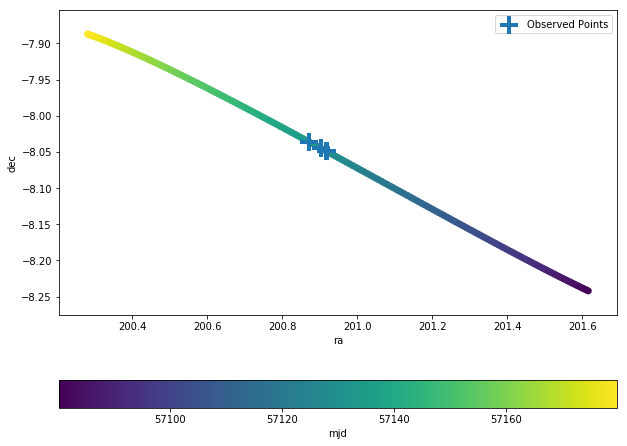

In [19]:
fig = orbit_info.plot_predicted_ra_dec(date_range)
fig.set_figheight(8)
fig.set_figwidth(10)

### Get predicted pixel locations in a new image

Take a new image and calculate the predicted pixel locations at given times for the object. Even though we use a single WCS it is useful to get an idea of where an object might be in a sequence of images taken of the same field.

In [20]:
new_image = str(
    "/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/"
    + "Pointing_Group_300/processed_data/rerun/rerun_processed_data/0434610/"
    + "calexp/calexp-0434610_22.fits"
)

new_times = np.arange(kbmod_info.mjd_0 + 1, kbmod_info.mjd_0 + 1.5, 0.1)

x_pix, y_pix = orbit_info.predict_pixels(new_image, new_times)

# Create a pandas dataframe with the predicted x, y locations
pixel_df = pd.DataFrame(np.array([new_times, x_pix, y_pix]).T, columns=["mjd", "pred_x_loc", "pred_y_loc"])
pixel_df.head()

,mjd,pred_x_loc,pred_y_loc
0,57131.274322,33.725132,3798.938113
1,57131.374322,27.826228,3777.955707
2,57131.474322,21.919779,3757.163791
3,57131.574322,16.022953,3736.566189
4,57131.674322,10.150093,3716.093801


### Recalculate orbit info with a new object

Recalculate everything on the fly by setting the path to a new MPC-formatted file.

In [21]:
# Use sample object included in pyOrbfit repo
orbit_info.set_orbit_and_obs_info("/epyc/users/brycek/dirac-pyOrbfit/2013_TV158.mpc")

### Plot orbital elements with uncertainties

Our main new feature is adding plotting utilities to visualize the orbital parameters space along with uncertainties in the fit. In addition, we draw a number of samples from the distribution and add those into the plot as well.

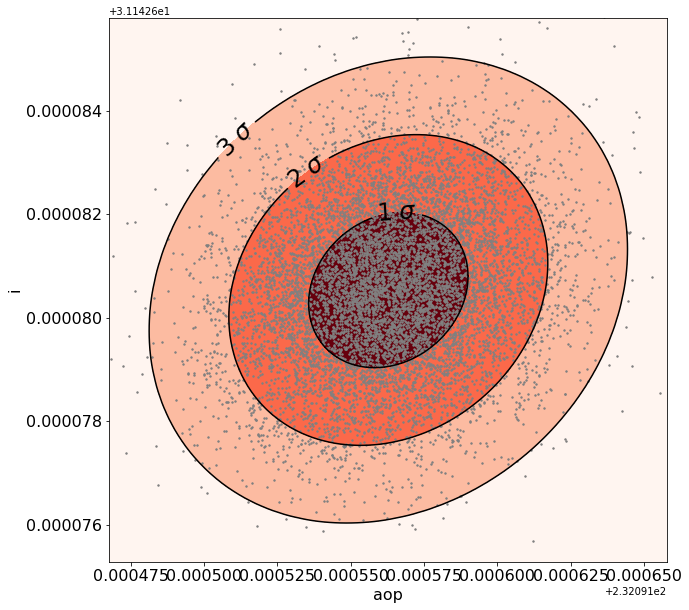

In [22]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("aei", "aop", "i", fig=fig)

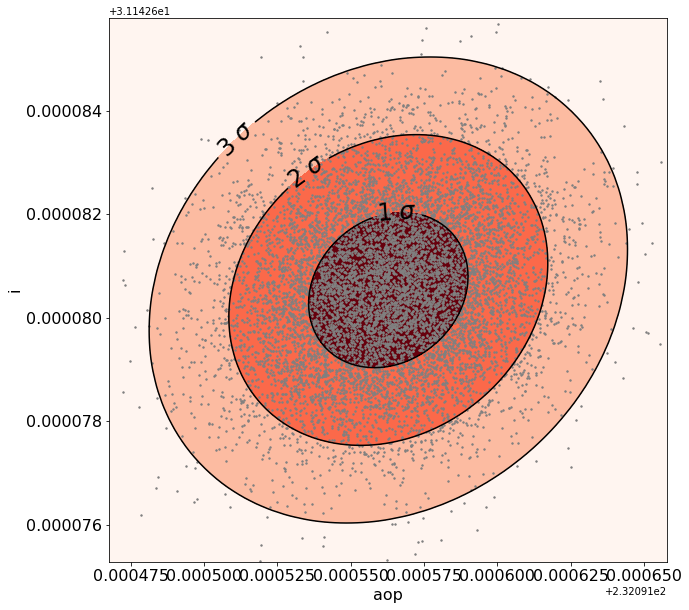

In [23]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("aei", "aop", "i", fig=fig)

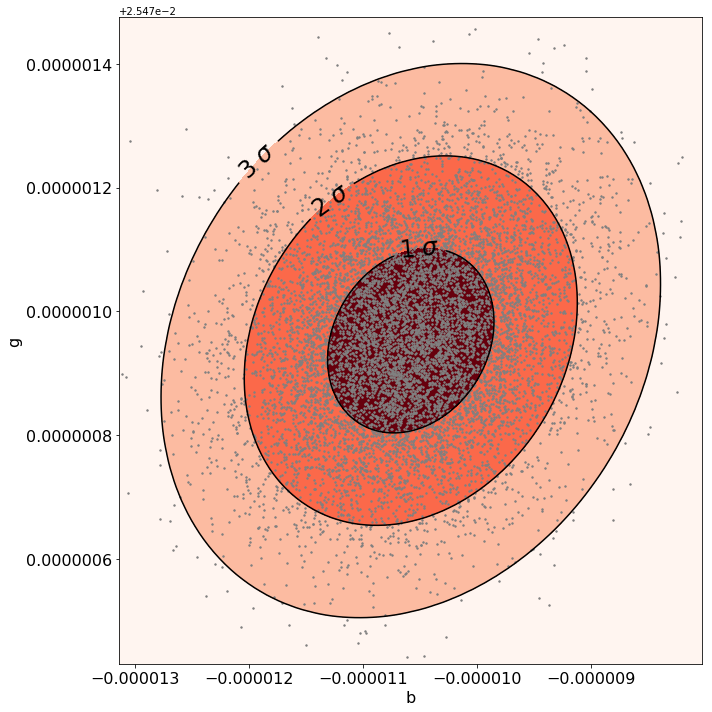

In [24]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("abg", "b", "g", fig=fig)
plt.tight_layout()

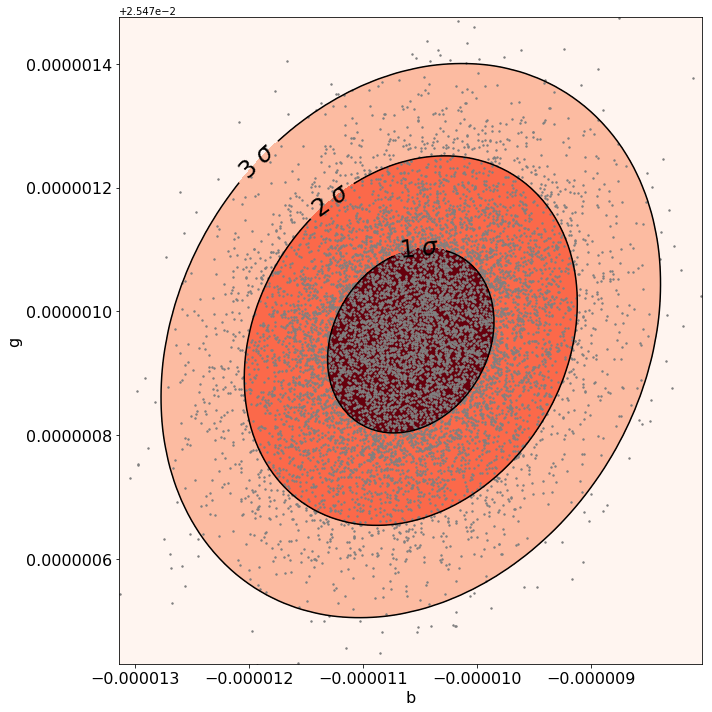

In [25]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("abg", "b", "g", fig=fig)
plt.tight_layout()

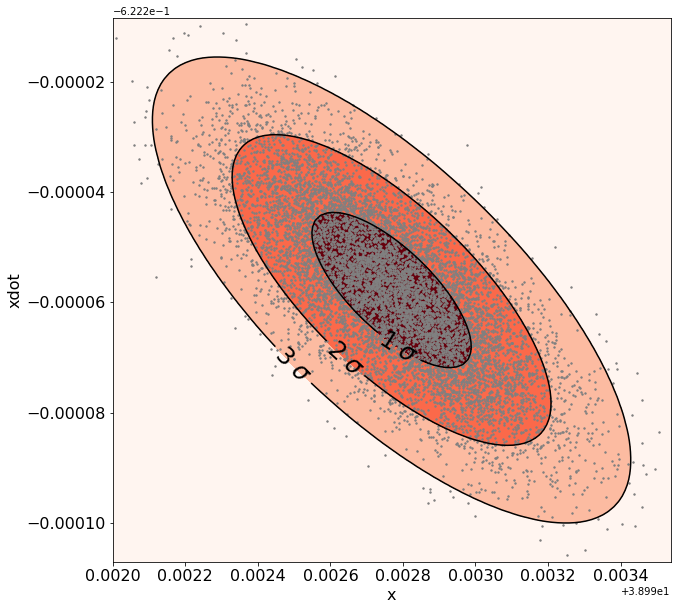

In [26]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("xyz", "x", "xdot", fig=fig)

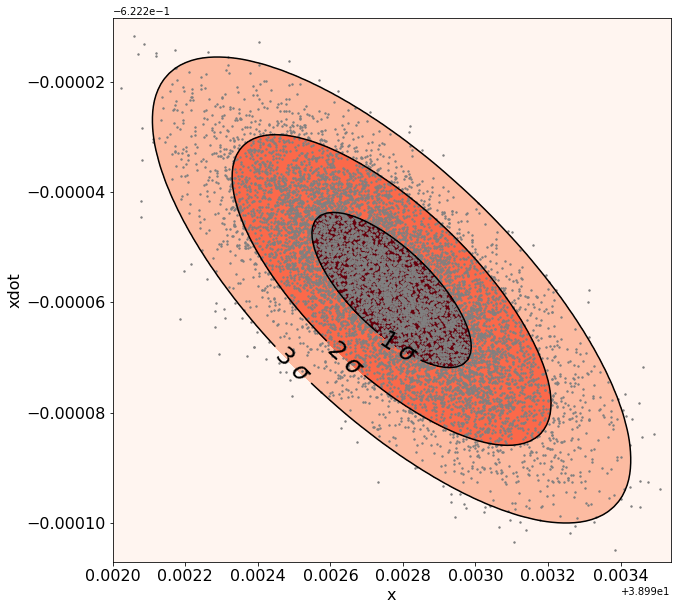

In [27]:
fig = plt.figure(figsize=(10, 10))
fig = orbit_info.plot_elements_uncertainty("xyz", "x", "xdot", fig=fig)

### Test `OrbitInfo` against pyOrbfit `plotEllipse` method

We expand upon the original `pyOrbfit` 1-$/sigma$ ellipse plotting routine. As a check we show the comparison here.

89.445726577557


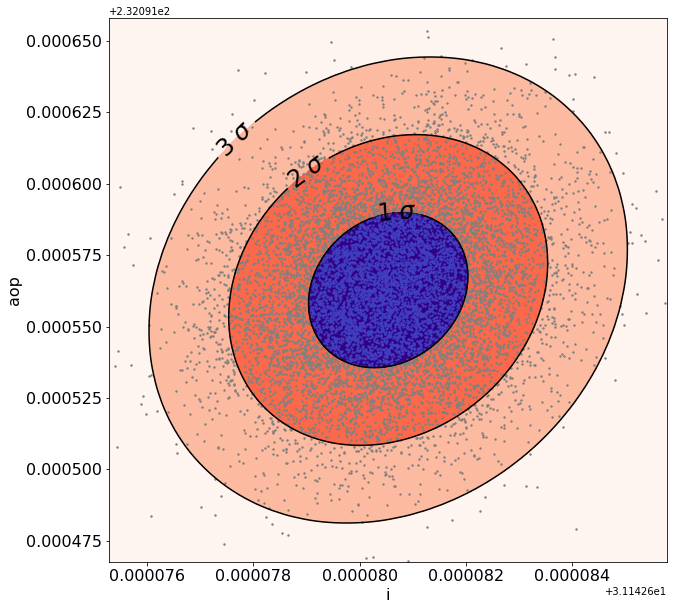

In [28]:
aei_el, aei_err = orbit_info.get_elements("aei")
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
ax.add_patch(orbit_info.orbit.plotEllipse([aei_el["i"], aei_el["aop"]], orbit_info.orbit.covar_aei, 2, 4))
fig = orbit_info.plot_elements_uncertainty("aei", "i", "aop", fig=fig)

Looks like the pyOrbfit method exactly matches our 1$\sigma$ contour

### Plot a corner plot with all 1-to-1 relationships.

We also have a function `plot_all_elements` to plot all the elements in a basis against one another in a corner plot style.

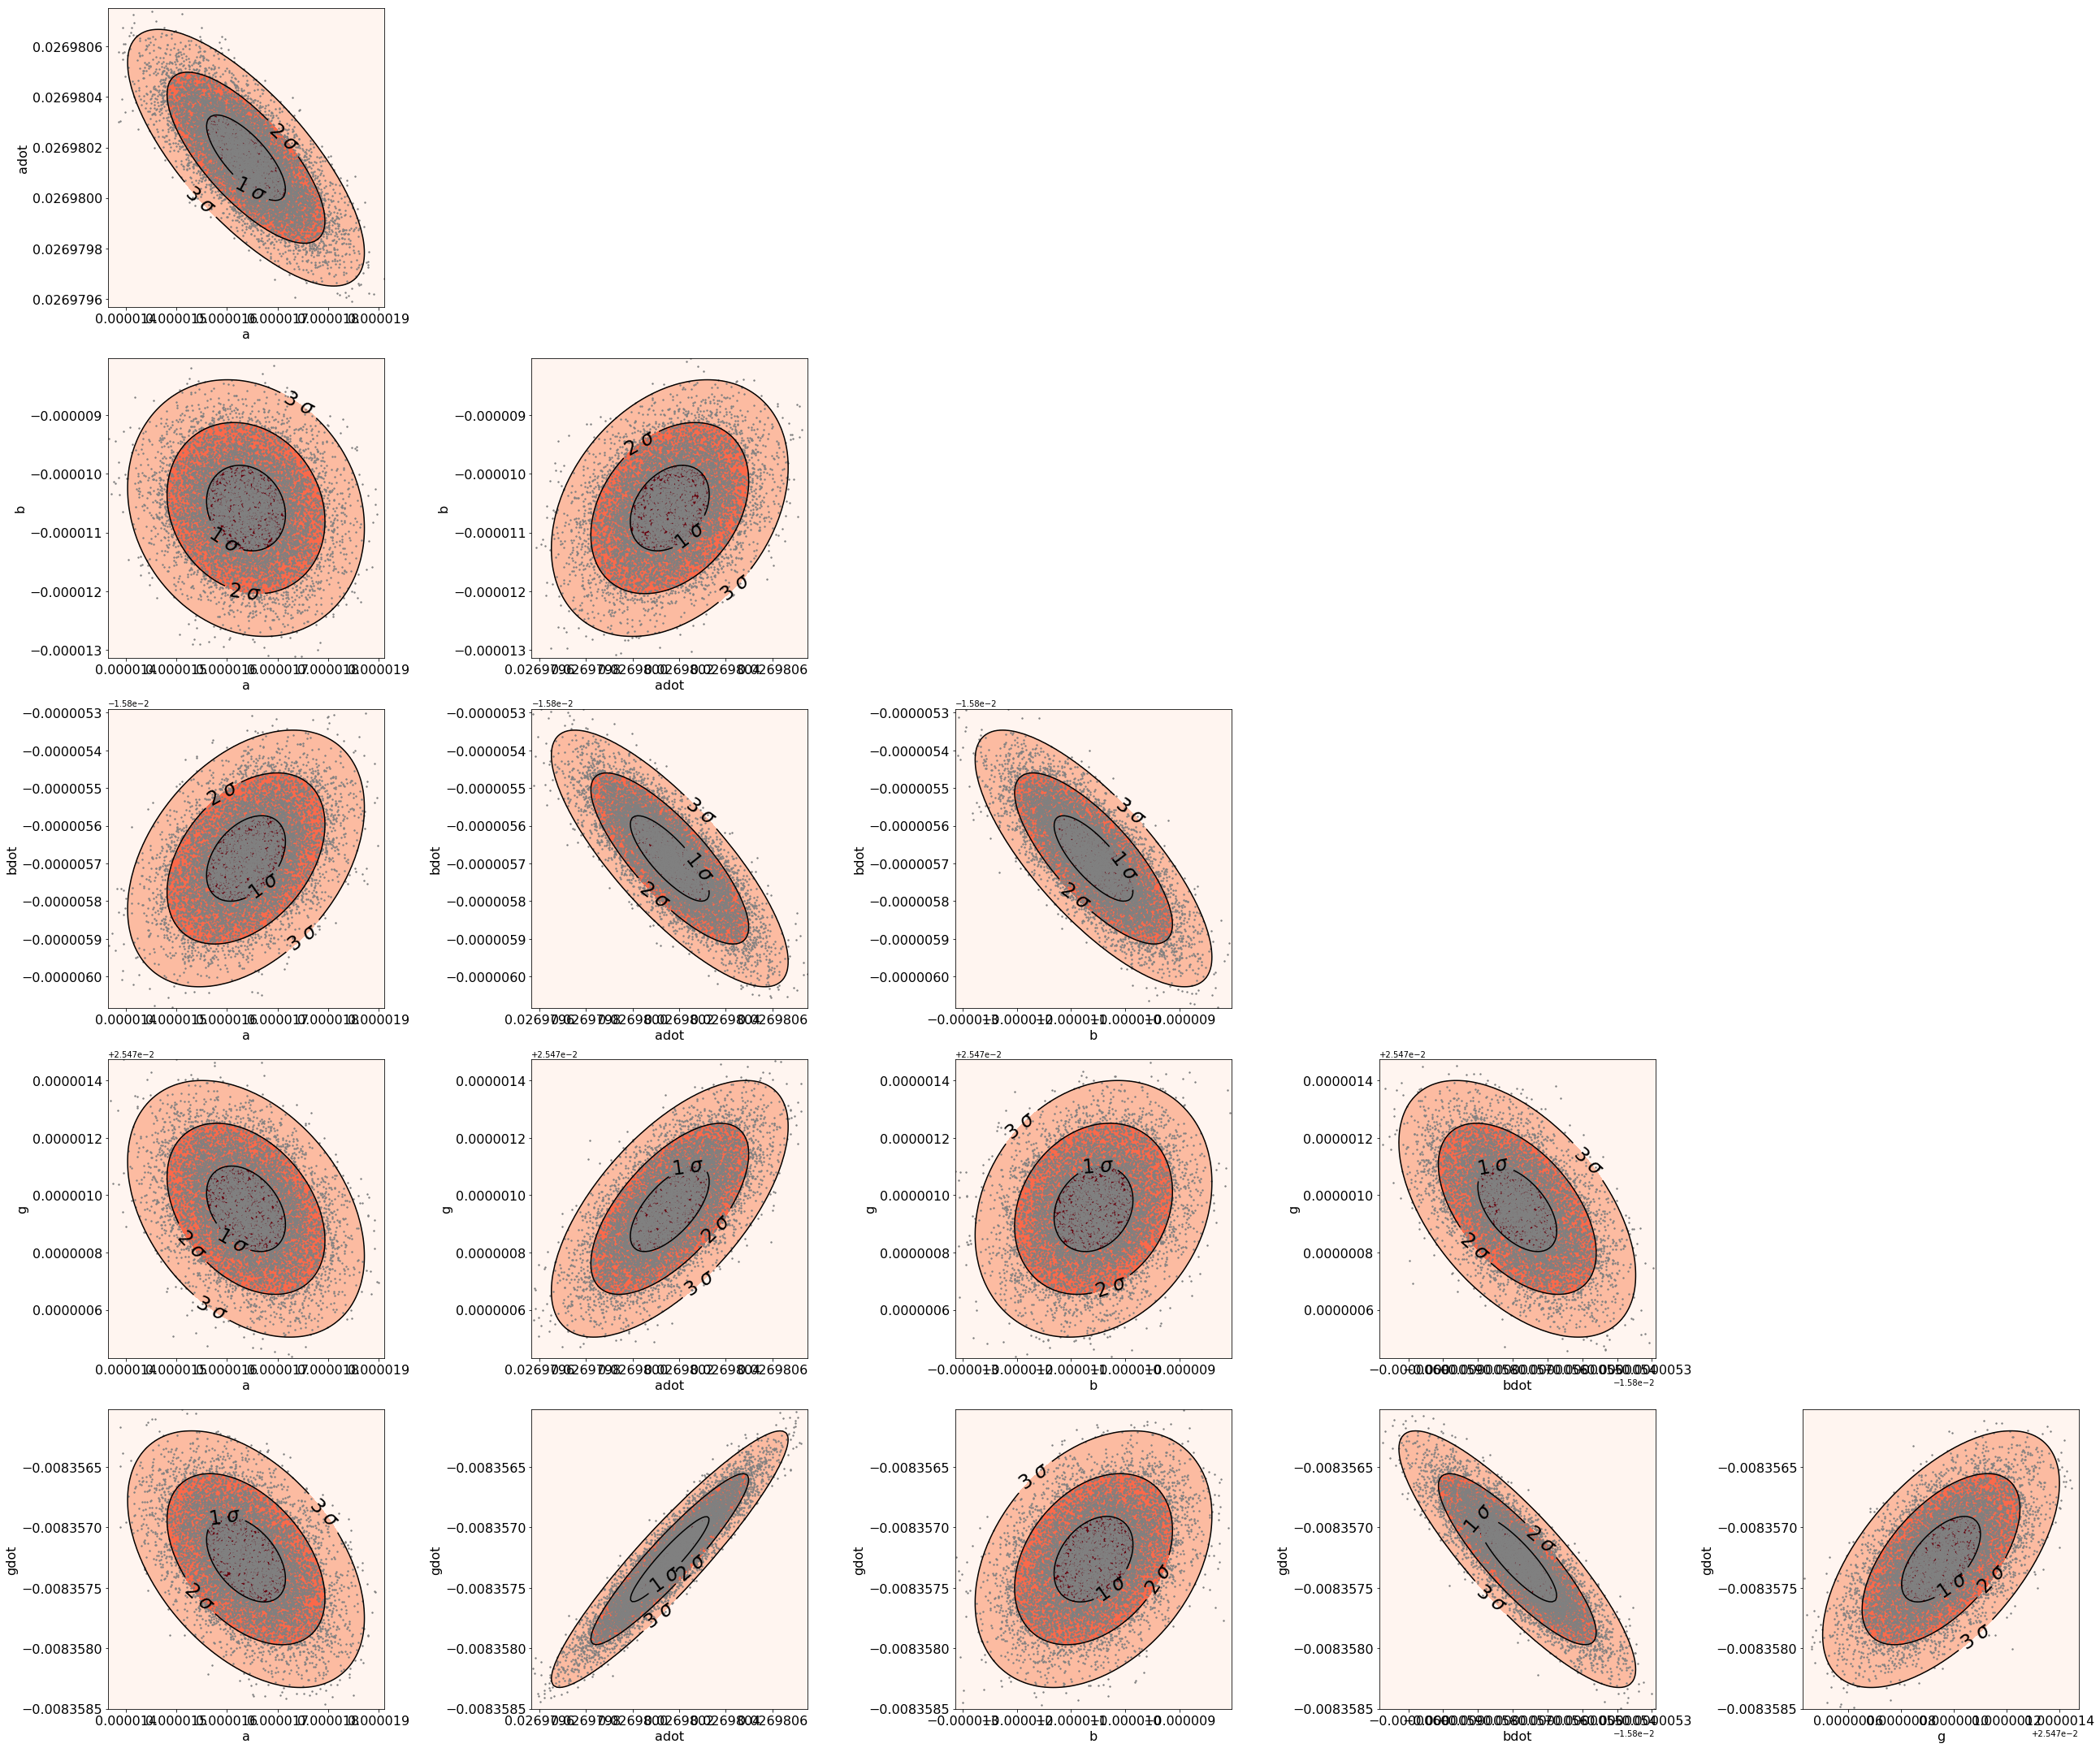

In [29]:
fig = plt.figure(figsize=(36, 30))
orbit_info.plot_all_elements("abg", fig=fig)
plt.tight_layout()

### Get the perihelion and aphelion values and plot

Finally we also include functions to get perihelion and aphelion values as well as plot them with their uncertainties.

In [30]:
elements, errs, cov = orbit_info.get_pq(return_cov=True)

In [31]:
elements, errs

({'p': 36.47099584517459, 'q': 185.97820882641628},
 {'p': 0.004994037062712788, 'q': 0.015546168487466578})

In [32]:
cov

array([[7.62062421e-08, 2.45043117e-06],
       [2.45043117e-06, 2.41683355e-04]])

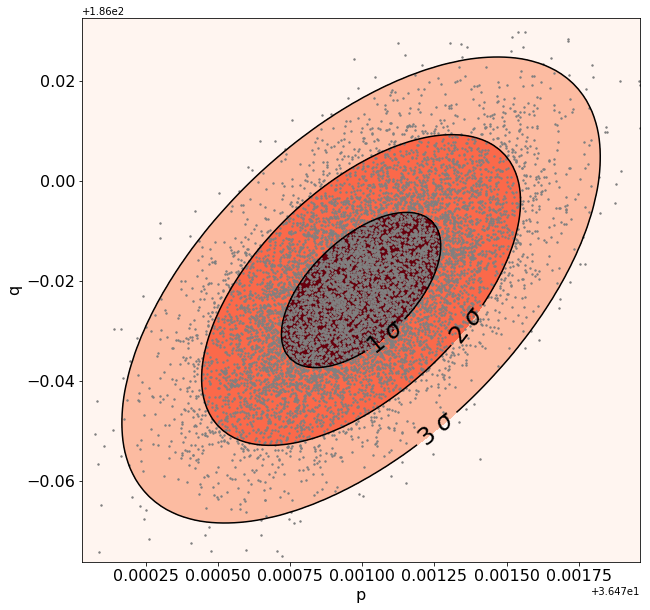

In [33]:
fig = plt.figure(figsize=(10, 10))
orbit_info.plot_pq_uncertainty(fig=fig)